### Install Dependencies

In [15]:
%pip install spacy
%pip install pandas
%pip install scikit-learn
%pip install tabulate
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Import Libraries

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy
from spacy.util import filter_spans
import random
from spacy.training.example import Example
from collections import defaultdict
from tabulate import tabulate
import matplotlib.pyplot as plt

### Load Data

In [17]:
df_ner = pd.read_json('datasets\Entity Recognition in Resumes.json', lines=True)
print(df_ner.head())
df_ner.drop(columns=['extras'], inplace=True)
df_ner.head()

<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
C:\Users\NoteBook\AppData\Local\Temp\ipykernel_21020\785819667.py:1: SyntaxWarning: invalid escape sequence '\E'
  df_ner = pd.read_json('datasets\Entity Recognition in Resumes.json', lines=True)


                                             content  \
0  Abhishek Jha\nApplication Development Associat...   
1  Afreen Jamadar\nActive member of IIIT Committe...   
2  Akhil Yadav Polemaina\nHyderabad, Telangana - ...   
3  Alok Khandai\nOperational Analyst (SQL DBA) En...   
4  Ananya Chavan\nlecturer - oracle tutorials\n\n...   

                                          annotation  extras  
0  [{'label': ['Skills'], 'points': [{'start': 12...     NaN  
1  [{'label': ['Email Address'], 'points': [{'sta...     NaN  
2  [{'label': ['Skills'], 'points': [{'start': 37...     NaN  
3  [{'label': ['Skills'], 'points': [{'start': 80...     NaN  
4  [{'label': ['Degree'], 'points': [{'start': 20...     NaN  


,content,annotation
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12..."
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta..."
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37..."
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80..."
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20..."


### Data Prep

In [18]:
df_ner['content'] = df_ner['content'].str.replace('\n',' ')
df_ner.head()

,content,annotation
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12..."
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta..."
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37..."
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80..."
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20..."


Convert to spaCy valid format

In [19]:
# Define the entity classes and initialize the data dictionary
data = {'classes': ["COLLEGE NAME", "LOCATION", "DESIGNATION",
                    "EMAIL ADDRESS", "NAME", "SKILLS"], 'annotations': []}

# Iterate over each row in the DataFrame to extract text and entity annotations
for _, row in df_ner.iterrows():
    temp_dict = {}
    temp_dict['text'] = row['content']  # The text content of the resume
    temp_dict['entities'] = []          # List to hold entity tuples for this text
    
    # Iterate over each annotation in the row
    for annotation in row['annotation']:
        if len(annotation['label']) != 0:  # Check if there is a label
            label = annotation['label'][0].upper()  # Get the label and convert to uppercase
            if label in data['classes']:            # Only keep labels that are in our classes
                for point in annotation['points']:  # There may be multiple points per annotation
                    start = point['start']          # Start character index of the entity
                    end = point['end']              # End character index of the entity
                    temp_dict['entities'].append((start, end, label))  # Add entity tuple
    data['annotations'].append(temp_dict)           # Add this example to the annotations list

# Display the first annotation example to verify the format
data['annotations'][0]

{'text': "Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company's growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILL

Split into training and test datasets

In [20]:

# Split annotations into train and test sets (80% train, 20% test)
train_annotations, test_annotations = train_test_split(
    data['annotations'], test_size=0.2, random_state=42
)

# Create separate dicts for train and test
train_data = {'classes': data['classes'], 'annotations': train_annotations}
test_data = {'classes': data['classes'], 'annotations': test_annotations}

print(f"Train size: {len(train_data['annotations'])}")
print(f"Test size: {len(test_data['annotations'])}")


Train size: 176
Test size: 44


Convert to list of Examples

In [21]:
# Create a blank English spaCy model (only tokenizer, no pre-trained pipeline)
nlp = spacy.blank("en")

# Function to convert data into a list of spaCy Doc objects for training
def convert_to_doc(data):
    docs_list = []  # List to store Doc objects
    
    # Loop through each annotated example in the data
    for example in data['annotations']:
        text = example['text']
        entities = example['entities']
        
        # Create a spaCy Doc object from the text
        doc = nlp.make_doc(text)
        ents = []
        
        # Loop through all entity annotations for this example
        for start, end, label in entities:
            # Create a span for each entity using character offsets and label
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is not None:
                ents.append(span)
            # If span is None, the entity annotation is skipped (misaligned indices)
        
        # Remove overlapping or invalid spans
        filtered_ents = filter_spans(ents)
        # Assign the filtered entities to the doc
        doc.ents = filtered_ents
        
        # Add the doc to the list
        docs_list.append(doc)
         
    return docs_list

# Convert the training and test data to lists of Doc objects
train_docs = convert_to_doc(train_data)
test_docs = convert_to_doc(test_data)

# Create Example objects for training (required by spaCy training API)
train_examples = []
for doc in train_docs:
    train_examples.append(Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}))
    
    
test_examples = []
for doc in test_docs:
    test_examples.append(Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}))
    

### Train model

In [22]:
# Load a blank English model
nlp = spacy.blank("en")

# Add the NER component to the pipeline
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# Add labels to the NER component
for label in train_data['classes']:
    ner.add_label(label)

loss_history = []

# Disable other pipeline components during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
    for itn in range(300):  # Number of training iterations
        random.shuffle(train_examples)
        losses = {}
        for batch in spacy.util.minibatch(train_examples, size=8):
            nlp.update(batch, drop=0.5, losses=losses)
        print(f"Iteration {itn+1}, Losses: {losses['ner']}")
        loss_history.append(losses['ner'])

# Save the trained model to disk
nlp.to_disk("ner_model_spacy")


Iteration 1, Losses: 54603.08203125
Iteration 2, Losses: 5223.263671875
Iteration 3, Losses: 4586.7763671875
Iteration 4, Losses: 4244.72314453125
Iteration 5, Losses: 3976.155517578125
Iteration 6, Losses: 3768.96435546875
Iteration 7, Losses: 3472.74658203125
Iteration 8, Losses: 3363.915283203125
Iteration 9, Losses: 3188.637939453125
Iteration 10, Losses: 3025.69384765625
Iteration 11, Losses: 2872.331787109375
Iteration 12, Losses: 2698.292236328125
Iteration 13, Losses: 2673.555419921875
Iteration 14, Losses: 2585.668701171875
Iteration 15, Losses: 2452.24951171875
Iteration 16, Losses: 2331.705078125
Iteration 17, Losses: 2272.363525390625
Iteration 18, Losses: 2214.2421875
Iteration 19, Losses: 2075.1962890625
Iteration 20, Losses: 2211.884521484375
Iteration 21, Losses: 2035.1881103515625
Iteration 22, Losses: 2024.2647705078125
Iteration 23, Losses: 1994.63232421875
Iteration 24, Losses: 1932.1033935546875
Iteration 25, Losses: 1960.9527587890625
Iteration 26, Losses: 1912.72

MemoryError: Unable to allocate 2.90 MiB for an array with shape (7925, 96) and data type float32

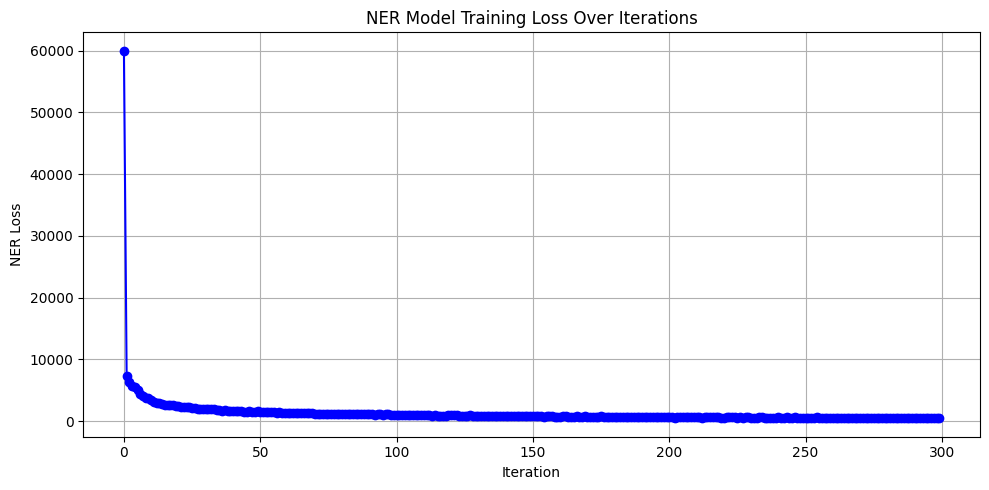

In [ ]:
# Plotting the loss curve
plt.figure(figsize=(10, 5))
plt.plot(loss_history, marker='o', linestyle='-', color='blue')
plt.title("NER Model Training Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("NER Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

### Evaluation
Entity level

In [ ]:
def print_evaluation_tables(evaluation):
    from tabulate import tabulate

    # Entity-level table
    entity_rows = []
    for entity, scores in evaluation["ents_per_type"].items():
        row = [
            entity.title(),  # Capitalize like "College Name"
            round(scores["f"], 3),
            round(scores["r"], 3),
            round(scores["p"], 3)
        ]
        entity_rows.append(row)

    print("Entity-Level Evaluation:")
    print(tabulate(
        entity_rows,
        headers=["Recognized Entity", "F-Score", "Recall", "Precision"],
        tablefmt="grid"
    ))

    # Token-level table (just one row)
    token_row = [[
        "All Tokens",
        round(evaluation["token_f"], 3),
        round(evaluation["token_r"], 3),
        round(evaluation["token_p"], 3)
    ]]

    print("\nToken-Level Evaluation:")
    print(tabulate(
        token_row,
        headers=["Recognized Entity", "F-Score", "Recall", "Precision"],
        tablefmt="grid"
    ))

evaluation = nlp.evaluate(test_examples)

# Example usage after evaluation
print_evaluation_tables(evaluation)


Entity-Level Evaluation:
+---------------------+-----------+----------+-------------+
| Recognized Entity   |   F-Score |   Recall |   Precision |
+=====================+===========+==========+=============+
| Name                |     1     |        1 |       1     |
+---------------------+-----------+----------+-------------+
| Designation         |     0.888 |        1 |       0.799 |
+---------------------+-----------+----------+-------------+
| Location            |     0.911 |        1 |       0.837 |
+---------------------+-----------+----------+-------------+
| Email Address       |     0.878 |        1 |       0.783 |
+---------------------+-----------+----------+-------------+
| College Name        |     0.882 |        1 |       0.789 |
+---------------------+-----------+----------+-------------+
| Skills              |     0.846 |        1 |       0.733 |
+---------------------+-----------+----------+-------------+

Token-Level Evaluation:
+---------------------+-----------+

Token level

In [ ]:

def compute_token_level_metrics_per_entity(nlp, examples):
    per_entity_counts = defaultdict(lambda: {"TP": 0, "FP": 0, "FN": 0})

    for example in examples:
        pred_doc = nlp(example.text)
        gold_doc = example.reference

        for pred_token, gold_token in zip(pred_doc, gold_doc):
            pred_ent = pred_token.ent_type_
            gold_ent = gold_token.ent_type_

            if pred_ent == gold_ent and pred_ent != "":
                per_entity_counts[pred_ent]["TP"] += 1
            elif pred_ent != gold_ent:
                if pred_ent != "":
                    per_entity_counts[pred_ent]["FP"] += 1
                if gold_ent != "":
                    per_entity_counts[gold_ent]["FN"] += 1

    # Compute precision, recall, f-score
    result_table = []
    for ent_type, counts in per_entity_counts.items():
        TP = counts["TP"]
        FP = counts["FP"]
        FN = counts["FN"]

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        result_table.append([ent_type.title(), round(f_score, 3), round(recall, 3), round(precision, 3)])

    # Sort alphabetically by entity name
    result_table.sort()

    return result_table


In [ ]:
# Token-level evaluation details
token_level_table = compute_token_level_metrics_per_entity(nlp, test_examples)
print("Token-Level Evaluation per Entity:")
print(tabulate(
    token_level_table,
    headers=["Recognized Entity", "F-Score", "Recall", "Precision"],
    tablefmt="grid"
))

Token-Level Evaluation per Entity:
+---------------------+-----------+----------+-------------+
| Recognized Entity   |   F-Score |   Recall |   Precision |
+=====================+===========+==========+=============+
| College Name        |     0.539 |    0.475 |       0.622 |
+---------------------+-----------+----------+-------------+
| Designation         |     0.48  |    0.427 |       0.547 |
+---------------------+-----------+----------+-------------+
| Email Address       |     0.766 |    0.788 |       0.745 |
+---------------------+-----------+----------+-------------+
| Location            |     0.429 |    0.321 |       0.643 |
+---------------------+-----------+----------+-------------+
| Name                |     0.91  |    0.871 |       0.953 |
+---------------------+-----------+----------+-------------+
| Skills              |     0.633 |    0.571 |       0.71  |
+---------------------+-----------+----------+-------------+
